## TODO:
song_id remove correlation matrix
0. ROC curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
1. Class imbalanbce (mid level imbalance 10-20% weak class) -- stratification fold shuffle method -- check effectiveness with
evaluation metrics
2. Evaluation (cross-validation) -- RepeatedKFold
3. Count plot per genre -- metadata


PLAN:
- Feature extraction
- Label creation - preproccessing (standardizatrion, EDA,std+deltas drop, visualization)
- Feature selection (Correlation matrix OR RandomFroset)
- Data split KFold
- Oversampling with SMOTE (imbalanceness)
- Training with GridSearch on SVC KFold
- Evaluation with confusion matrix + 4 tp,tn,fn,fp
- Plot ROC curve, precision and recall

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/tyiannak/pyAudioAnalysis.git
! pip install -r /content/pyAudioAnalysis/requirements.txt


Cloning into 'pyAudioAnalysis'...
remote: Enumerating objects: 3041, done.
remote: Counting objects: 100% (514/514), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 3041 (delta 429), reused 397 (delta 397), pack-reused 2527
Receiving objects: 100% (3041/3041), 167.65 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (1817/1817), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 15.3 MB/s eta 0:00:00


In [ ]:
!apt-get install -y ffmpeg eyed3
!pip install pyAudioAnalysis


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  python3-eyed3 python3-magic
Suggested packages:
  python3-pil python3-pylast python3-requests
The following NEW packages will be installed:
  eyed3 python3-eyed3 python3-magic
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 115 kB of archives.
After this operation, 593 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 python3-magic all 2:0.4.24-2 [12.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-eyed3 all 0.8.10-4 [91.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 eyed3 all 0.8.10-4 [11.3 kB]
Fetched 115 kB in 1s (210 kB/s)
Selecting previously unselected package python3-magic.
(Reading database ... 121749 files and directories currently installed.)
Pr

## Choosing the dataset

Our project subject is emotion classification in songs.
For this, we decided to find a dataset that consisted of the audio files and some annotated data as well that could enrich our model to additional useful features. The dataset we came across was the DEAM dataset [SOURCE: *Aljanaki, Anna & Yang, yi-hsuan & Soleymani, Mohammad. (2017). Developing a benchmark for emotional analysis of music. PLOS ONE. 12. e0173392. 10.1371/journal.pone.0173392.*].

DEAM consists of 2058 45-sec song clips of various genres and some provided labeled data which is the metadata, audio features and the valence & arousal label values in short term wondows and long term for the whole song.
From the given dataset, only 1744/2058 were correctly and fully annotated.
Also, we decided to extract our own audio features and use only valence & arousal provided as the target labels.

The metadata files provided from DEAM were not very well annotated and needed some manual preproccessing. From the metadata datasets, we could only use one column entry, wich described the Genre of most of the annotated songs.

For our model, we used the song average values of valence and arousal that has been annotated by experts. are annotated by experts. Valence and arousal are audio properties closely related to emotion. Based on Thayer's theory, depending on the combination of values of valence and arousal of an audio signal, we can determine its emotion.
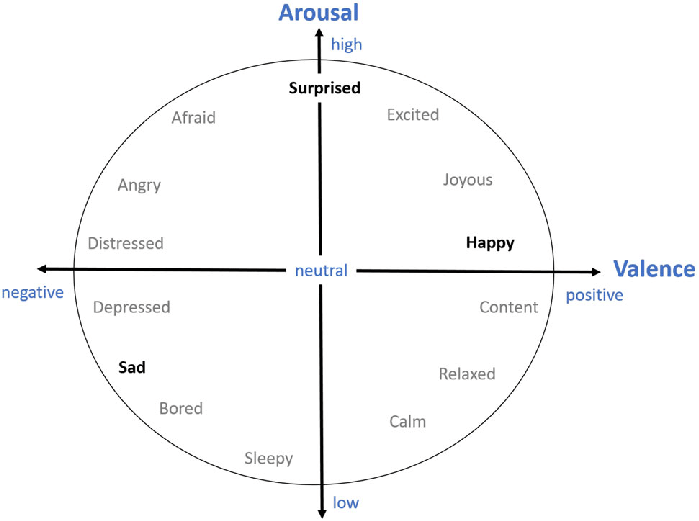


( source: Yang, yi-hsuan & Lin, Yu-Ching & Cheng, Heng-Tze & Liao, I-Bin & Ho, Yeh-Chin & Chen, Homer. (2008). Toward Multi-modal Music Emotion Classification. 70-79. 10.1007/978-3-540-89796-5_8. )

Based on these values, we extract the target labels for each emotion our model will try to predict. More on this process during the feature extraction

In [ ]:
api_token = {"username":"lspart","key":"589f3fdd7c941d7f8b97f7e4a8423cbd"}

import json
import os

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
%mkdir data
%cd data

/content/data


In [ ]:
!kaggle datasets download -d imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music
db_ilepath = '/content/data/deam-mediaeval-dataset-emotional-analysis-in-music'
%mkdir deam-mediaeval-dataset-emotional-analysis-in-music
%mv deam-mediaeval-dataset-emotional-analysis-in-music.zip deam-mediaeval-dataset-emotional-analysis-in-music
%cd deam-mediaeval-dataset-emotional-analysis-in-music
!unzip deam-mediaeval-dataset-emotional-analysis-in-music.zip


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
mv: cannot stat 'deam-mediaeval-dataset-emotional-analysis-in-music.zip': No such file or directory
/content/deam-mediaeval-dataset-emotional-analysis-in-music
unzip:  cannot find or open deam-mediaeval-dataset-emotional-analysis-in-music.zip, deam-mediaeval-dataset-emotional-analysis-in-music.zip.zip or deam-mediaeval-dataset-emotional-analysis-in-music.zip.ZIP.


## Feature extraction

To extract the meaningful audio features, we used pyAudioAnalysis to extract the mid term features of each song. We used the mean values of the extracted features. After testing, it was noticed that deltas values and std values were dropping the accuracy of the model, so we will preproccess the extracted features by droppping these values.

In [ ]:
# Midterm (and optional shortterm) audio feature extraction
# Given a folder of all wav or mp3 input data songs,
# call midterm feature extraction, create the pandas dataframe
# and save a csv and pkl file.
#
# If pkl already exists, load it and return the dataframe
############## DO MP3 TO WAV CONVERTION CELL FIRST

import os
import pandas as pd
from pyAudioAnalysis import MidTermFeatures as mtf
from pyAudioAnalysis import ShortTermFeatures, audioBasicIO
import pickle
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def audio_feature_extraction(deam_audio_path, pkl_path, shortTerm = False):
    all_mid_term_features = []
    all_files = []
    all_feature_names = []
    if os.path.isfile(pkl_path):
        with open(pkl_path,'rb') as f:
            mid_term_features_2 = pickle.load(f)
            ### the commented is needed for midterm_audio_full.pkl
            ## new version saved all info into one pkl->file total_data_csv
            #wav_file_list2 = pickle.load(f)
            #mid_feature_names = pickle.load(f)
            all_mid_term_features = mid_term_features_2
            print('extracted!')
            wavFeatures_df = pd.DataFrame(all_mid_term_features)

            print(wavFeatures_df.head())
    else:
        with open(pkl_path,'wb') as f:
            if shortTerm:
                    # this loop is for using ShortTermFeature. Otherwise, comment it
                j = 0
                for fille in dir:
                    # computes all audio features of wav files in given folder
                    [Fs, x] = audioBasicIO.read_audio_file(deam_audio_path + fille)
                    #print(Fs,x.shape)
                    if len(x.shape) == 1:
                        mid_term_features_2, mid_feature_names = ShortTermFeatures.feature_extraction(x, Fs, 0.08*Fs, 0.08*Fs)
                    else:
                        mid_term_features_2, mid_feature_names = ShortTermFeatures.feature_extraction(x[:,0], Fs, 0.08*Fs, 0.08*Fs)
                    #print(F.shape, feature_names, len(feature_names))

                    all_mid_term_features.append(mid_term_features_2)
                    all_feature_names.append(mid_feature_names)
                    all_files.append(fille)

                    j += 1
            else:
                mid_term_features, wav_file_list2, mid_feature_names = mtf.directory_feature_extraction(deam_audio_path ,1,1, 0.080, 0.08)
                # Append the features and file information to the lists
                print(mid_term_features, wav_file_list2, mid_feature_names)
                # Save before standardization
                wavFeatures_df = pd.DataFrame(mid_term_features)
                if shortTerm != True:
                    for i,filename in enumerate(wav_file_list2):
                        filename = filename.split('/')[-1]
                        wav_file_list2[i] = filename.split('.')[0]
                wavFeatures_df.columns = [mid_feature_names]
                wavFeatures_df['song_id'] = wav_file_list2
                ffile = open('unnormalized_midterm.pkl', 'wb')
                pickle.dump(wavFeatures_df, ffile)
                ffile.close()
                # Standardization
                m = mid_term_features.mean(axis=0)
                s = np.std(mid_term_features, axis = 0)
                print(s)
                mid_term_features_2 = (mid_term_features - m) / s
                all_mid_term_features = mid_term_features_2
                all_feature_names = mid_feature_names
                all_files = mid_feature_names

                print(all_mid_term_features, all_feature_names)
            # in shorttermffeatures, here it is an array. Change to mid_term+features_2 and wav_file_list2
            #all_mid_term_features = all_mid_term_features.reshape(-1, all_mid_term_features.shape[2])

            # we now have all sound features extracted from wav files
            # print dimensions
            print(len(all_mid_term_features))
            wavFeatures_df = pd.DataFrame(all_mid_term_features)
            # cahnge the wav_filename_list to just the filename (song_id)
            if shortTerm != True:
                for i,filename in enumerate(wav_file_list2):
                    filename = filename.split('/')[-1]
                    wav_file_list2[i] = filename.split('.')[0]

            wavFeatures_df.columns = [mid_feature_names]
            wavFeatures_df['song_id'] = wav_file_list2

            pickle.dump(wavFeatures_df, f)
            print(wavFeatures_df.head())
    wavFeatures_df.to_csv('mid_audio_full.csv')
    # create dataframe and return it
    return wavFeatures_df


### utility functions
def pkl_to_pd(pkl_path):
    with open(pkl_path,'rb') as f:
        mid_term_features_2 = pickle.load(f)
    return mid_term_features_2

def csv_to_pd(csv_path):
    return pd.read_csv(csv_path, index_col=0)
def pd_to_csv(pd_path):
    return pd.read_csv(pd_path, index_col=0)
def pd_to_pkl(dff, pkl_path):
    ffile = open(pkl_path, 'wb')
    pickle.dump(dff, ffile)
    ffile.close()

In [ ]:
# example extraction of a given dataset
pkl_path = '/content/drive/MyDrive/ai_unipi/MachineLearning/media/midterm_audio_full.pkl'
total_data_csv = '/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_data.csv'

total_pd = csv_to_pd(total_data_csv)
pd_to_pkl(total_pd, '/content/total_data.pkl')
aa = audio_feature_extraction('/content/', '/content/total_data.pkl', False)

extracted!
   zcr_mean  energy_mean  energy_entropy_mean  spectral_centroid_mean  \
0 -0.174710    -0.774566             0.030276               -0.200111   
1  0.380791     1.045841             0.365854                0.377840   
2  0.292477    -0.063243             0.840085               -0.128733   
3 -0.983304    -1.044797            -0.374764               -0.806344   
4 -0.344802    -1.084248            -2.433123                0.231515   

   spectral_spread_mean  spectral_entropy_mean  spectral_flux_mean  \
0             -0.004680              -0.193153            0.864971   
1              0.217572               0.305879           -0.469400   
2             -0.409315               0.145741           -0.818416   
3             -0.071832              -0.846609            1.969040   
4              0.188764               0.176503            2.567123   

   spectral_rolloff_mean  mfcc_1_mean  mfcc_2_mean  ...  delta chroma_10_std  \
0              -0.282300    -0.876862     0.07338

Preproccessing:

Based on the Thayer's model, we set 4 classes / emotions. Since the values of arousal and valence in theprovided DEAM annotations are in range 1-9, we set a threshold of value 5 and create a new column 'emotino' based on the values of valence and arousal around that threshold:

* happy: Valence > 5 and Arousal >5
* calm: Valence > 5 and Arousal < 5
* anger: Valence <5 and Arousal > 5
* sad: Valence < 5 and Arousal < 5


Below get_features() function returns a pandas Dataframe with all audio features and the new created column 'emotion' specifying one of the 4 above emotions based on the given arousal & valence values.

In [ ]:
import pandas as pd
import os
import csv

# Creates Final CSV of audio features + valence&arousal labels
# deampath: the path of th eDEAM dataset containing
#           valence&arousal label annotations
# csv_audio_features_path: path of the extracted audio features csv
def get_features(deam_path, csv_audio_features_path):
    emotions = ["happy", # Valence > 0 and Arousal >0
        "calm"   # Valence > 0 and Arousal < 0
        "angry",  # Valence <0 and Arousal > 0
        "sad",  # Valence < 0 and Arousal < 0
    ]

    au_df = csv_to_pd(csv_audio_features_path)
    print(au_df.head())
    df = pd.read_csv(deam_path, usecols=['song_id', ' valence_mean', ' arousal_mean'])
    print(df[' arousal_mean'].min(), df[' arousal_mean'].max())
    print(df[' valence_mean'].min(), df[' valence_mean'].max())
    # Rename columns
    df.rename(columns = {' valence_mean':'valence'}, inplace = True)
    df.rename(columns = {' arousal_mean':'arousal'}, inplace = True)

    total_data = pd.DataFrame(au_df)

    # go row by row, coz some annotations missing from DEAM
    for indfex, row in df.iterrows():
        if row['song_id'] in total_data['song_id'].values:
            total_data.loc[total_data['song_id'].values == row['song_id'], 'valence'] = row['valence']
            total_data.loc[total_data['song_id'].values == row['song_id'], 'arousal'] = row['arousal']
    print(total_data.head())

    # create the labels
    for indfex, row in total_data.iterrows():
      if row['valence'] >= 5 and row['arousal'] >= 5:
          total_data.at[indfex, 'emotion'] = 1
      if row['valence'] >= 5 and row['arousal'] < 5:
          total_data.at[indfex, 'emotion'] = 2
      if row['valence'] < 5 and row['arousal'] >= 5:
          total_data.at[indfex, 'emotion'] = 3
      if row['valence'] < 5 and row['arousal'] < 5:
          total_data.at[indfex, 'emotion'] = 4
    print('done')
    print(total_data)

    # since some annotations were missing,
    # create a test dataset with the missing annotations
    empty_values_df = total_data[total_data['valence'].isnull()]
    empty_values_df = empty_values_df.drop(columns=['valence','arousal','emotion'])
    print(empty_values_df)

    # and only keep fully annotated data for training
    total_data = total_data.dropna()
    TotalData_df = pd.DataFrame(total_data)
    #TotalData_df.columns = ['song',  'emotion', 'arousal', "valence"]
    TotalData_df.to_csv("total_data.csv",index=False)


    return TotalData_df, empty_values_df

# read metadata provided DEAM file and return pd
def get_metadata_pd (metadata_path, output_csv_path):
    dataframes = []

    for file in os.listdir(metadata_path):
        meta_df = pd.read_csv(file)
        dataframes.append(meta_df)

    final_meta_df = pd.concat(dataframes, ignore_index=True)
    final_meta_df.to_csv(output_csv_path, index=False)
    print(final_meta_df.head())
    return final_meta_df

# get pd of metadata&audio features
def merge_feat_and_metadata (mid_term_csv_path, meta1, meta2, meta3):
    # metadata is split into 3 groups, total 2058 songs
    # midterm features are 1802 of these songs
    # so for all 3 metadata files, loop and attach the entry with 'song_id' same as mid_term_feature 'song_id'

    audio_df = pd.read_csv(mid_term_csv_path)
    audio_df=pd.DataFrame(audio_df)
    meta_df1 = pd.read_csv(meta1)
    meta_df2 = pd.read_csv(meta2)
    meta_df3 = pd.read_csv(meta3)

    meta_df1 = pd.DataFrame(meta_df1)
    meta_df2 = pd.DataFrame(meta_df2)
    meta_df3 = pd.DataFrame(meta_df3)
    # merge audio features and metadata features
    #frames = [audio_df, metaDF['genre']]
    # TotalData_df = pd.concat(frames)
    metas = [meta_df1, meta_df2, meta_df3]
    audio_df.reset_index(drop=True)
    for meta_df in metas:
        meta_df.reset_index(drop=True)
        for indfex, row in audio_df.iterrows():
            if audio_df['song_id'] == meta_df['song_id']:
                audio_df['Genre'] = meta_df['Genre']
    return audio_df

In [ ]:
### get final dataframe of both features and labels (already saved in file total_data.csv)
## and a dataframe of just features, no labels
tt, ee = get_features('/content/drive/MyDrive/ai_unipi/MachineLearning/media/static_annotations_averaged_songs_1_2000.csv', '/content/drive/MyDrive/ai_unipi/MachineLearning/media/mid_audio_full.csv')
# save features+labels and features datasets to csv
tt.to_csv('/content/total_annotated_data.csv')
ee.to_csv('/content/total_not_annotated_data.csv')
print(tt.shape)

   zcr_mean  energy_mean  energy_entropy_mean  spectral_centroid_mean  \
0 -0.174710    -0.774566             0.030276               -0.200111   
1  0.380791     1.045841             0.365854                0.377840   
2  0.292477    -0.063243             0.840085               -0.128733   
3 -0.983304    -1.044797            -0.374764               -0.806344   
4 -0.344802    -1.084248            -2.433123                0.231515   

   spectral_spread_mean  spectral_entropy_mean  spectral_flux_mean  \
0             -0.004680              -0.193153            0.864971   
1              0.217572               0.305879           -0.469400   
2             -0.409315               0.145741           -0.818416   
3             -0.071832              -0.846609            1.969040   
4              0.188764               0.176503            2.567123   

   spectral_rolloff_mean  mfcc_1_mean  mfcc_2_mean  ...  delta chroma_7_std  \
0              -0.282300    -0.876862     0.073389  ...      

In [ ]:
# Define feature data and labels
import numpy as np
import pandas as pd
feature_path = '/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_annotated_data.csv'

data = csv_to_pd(feature_path)
X = np.array(data.iloc[:, :-3].values)#.T
y = np.array(data['emotion'])
y_r = np.array([data['valence'],data['arousal']])
print(y_r)
feature_names = data.columns.values
print(X.shape)
print(y.shape)
print(feature_names)

[[4.  6.8 4.4 ... 6.  6.4 4.1]
 [4.7 5.6 3.8 ... 6.7 6.7 5.9]]
(1744, 139)
(1744,)
['zcr_mean' 'energy_mean' 'energy_entropy_mean' 'spectral_centroid_mean'
 'spectral_spread_mean' 'spectral_entropy_mean' 'spectral_flux_mean'
 'spectral_rolloff_mean' 'mfcc_1_mean' 'mfcc_2_mean' 'mfcc_3_mean'
 'mfcc_4_mean' 'mfcc_5_mean' 'mfcc_6_mean' 'mfcc_7_mean' 'mfcc_8_mean'
 'mfcc_9_mean' 'mfcc_10_mean' 'mfcc_11_mean' 'mfcc_12_mean' 'mfcc_13_mean'
 'chroma_1_mean' 'chroma_2_mean' 'chroma_3_mean' 'chroma_4_mean'
 'chroma_5_mean' 'chroma_6_mean' 'chroma_7_mean' 'chroma_8_mean'
 'chroma_9_mean' 'chroma_10_mean' 'chroma_11_mean' 'chroma_12_mean'
 'chroma_std_mean' 'delta zcr_mean' 'delta energy_mean'
 'delta energy_entropy_mean' 'delta spectral_centroid_mean'
 'delta spectral_spread_mean' 'delta spectral_entropy_mean'
 'delta spectral_flux_mean' 'delta spectral_rolloff_mean'
 'delta mfcc_1_mean' 'delta mfcc_2_mean' 'delta mfcc_3_mean'
 'delta mfcc_4_mean' 'delta mfcc_5_mean' 'delta mfcc_6_mean'
 'delta 

Visualizing the emotion count of all the songs in the dataset.

It looks like the class for happy and angry are outweighing the other 2 classes. We have around 11% of coverage for each of the other weaker classes. This means, there is a medium level of **imbalanceness**!
To solve this issue, we will use simple oversampling on the weaker classes (2 and 3) and will also try random under sampling on the prominent ones.


This will be shown during the train-test split later.

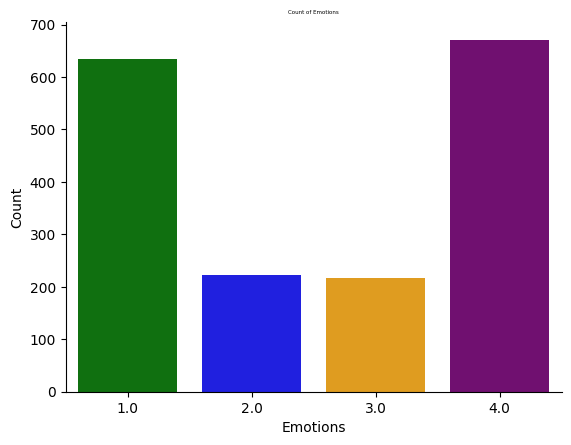

In [ ]:
### Visualizing different labels count
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=4)
sns.countplot(x='emotion', data=data, palette=['green', 'blue', 'orange', 'purple'])
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# SCATTERPLOT for feature selection
# Define colors for each label
#colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange'}
#print(data.iloc[:, :-3].values)
# plot based on 2 features their scatter of all 4 emotions
# we shall choose features with more discernible scatters
#### this method is too counterproductive to take all combinations of all 140 features!!
#plt.scatter(data.iloc[:, -1].values , data.iloc[:, 0].values, c=data['emotion'].map(colors))
#plt.legend()
#plt.show()


## Feature selection



In [ ]:
## dataset without the std values
filter_columns = list(range(0, 67)) + list(range(136, 141))
print(data.shape)
midterm_mean = data.iloc[:, filter_columns].copy()
## dataset without the deltas and std values (short term features)
filter_columns = list(range(0, 34)) + list(range(136, 141))
short_term = data.iloc[:, filter_columns].copy()

midterm_mean.to_csv("/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_data_no_std.csv",index=False)
short_term.to_csv("/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_data_no_std_no_deltas.csv",index=False)

X_means = np.array(short_term.iloc[:, :-3].values)#.T
y_means = np.array(data['emotion'])
y_means_r = np.array([short_term['valence'],short_term['arousal']])

no_std = 2
if no_std == 2:
    X = X_means
    y = y_means
    y_r = y_means_r

print(X.shape)

(1744, 142)
(1744, 36)


In [ ]:
short_term.iloc[:, :-3]

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,bpm,ratio
0,-0.174710,-0.774566,0.030276,-0.200111,-0.004680,-0.193153,0.864971,-0.282300,-0.876862,0.073389,...,0.193813,0.206704,0.012927,-0.227592,-0.122758,-0.297366,-0.308267,0.036901,1.724055,-0.305389
1,0.380791,1.045841,0.365854,0.377840,0.217572,0.305879,-0.469400,0.270129,1.256673,-0.584797,...,0.101932,-0.646363,-0.163170,-0.576274,-0.425148,0.677185,-0.621250,-0.026535,0.084761,0.379391
2,0.292477,-0.063243,0.840085,-0.128733,-0.409315,0.145741,-0.818416,0.356293,0.946473,-0.542595,...,-0.121987,0.883973,-0.319942,-0.943038,-0.256045,-0.795179,-0.219743,-1.034127,-0.383609,-0.183832
3,-0.983304,-1.044797,-0.374764,-0.806344,-0.071832,-0.846609,1.969040,-0.845289,-2.637234,1.081280,...,0.735090,-0.438844,-0.289533,1.113822,0.211428,0.509506,0.525837,1.490611,0.740479,-0.560611
4,-0.344802,-1.084248,-2.433123,0.231515,0.188764,0.176503,2.567123,0.257278,-2.457387,-0.012022,...,-0.166204,-0.023060,-0.696779,-1.176260,-0.644117,-1.073923,-0.216960,-0.105543,1.724055,0.492607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,0.838604,1.993246,-1.710779,2.109487,2.720483,0.687204,-0.177089,0.821288,1.193196,-0.277248,...,-0.141343,-0.111968,0.324204,0.709183,-0.230099,0.299772,-0.446246,-0.503256,-0.734887,-0.449304
1798,1.366235,-0.556953,1.202746,1.035852,0.690771,1.493685,-1.174024,1.181664,0.907262,-0.949729,...,-0.932308,-0.572279,-1.021814,-1.062896,0.147244,0.147417,1.850628,-1.347832,0.084761,0.894322
1799,0.785507,0.004841,-0.740913,0.238785,-0.651252,1.272343,-0.707278,0.798689,0.735869,-1.329181,...,-0.409976,-0.232239,-0.494367,-0.234539,-0.214052,-0.110873,-0.112775,-0.820886,-0.383609,0.856923
1800,0.487497,0.439203,-1.930553,-0.036658,-1.015471,1.010040,-0.584056,0.523388,0.817299,-0.654992,...,-0.449520,-0.768251,1.118263,-0.011360,0.780202,-0.554736,-0.419202,-0.473159,-0.383609,-0.524316


### Correlation matrix between input features

https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

We will find the correlation value between features vs features and features vs label. The higher the correlation between features is, the less important they are, while the opposite is true for feature vs label.

* 0.9 to 1 or -0.9 to -1 --> Perfect Correlation

* 0.5 to 0.9 or -0.5 to -0.9 --> Strong

* 0.1 to 0.5 or -0.1 to -0.5 --> Weak

* 0.0 to 0.1 or 0.0 to -0.1 --> Uncorrelated

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1801
Columns: 141 entries, zcr_mean to emotion
dtypes: float64(141)
memory usage: 1.9 MB
None
Dataset after 38 dependent features droped:     zcr_mean  energy_mean  energy_entropy_mean  spectral_centroid_mean  \
0 -0.174710    -0.774566             0.030276               -0.200111   
1  0.380791     1.045841             0.365854                0.377840   
2  0.292477    -0.063243             0.840085               -0.128733   
3 -0.983304    -1.044797            -0.374764               -0.806344   
4 -0.344802    -1.084248            -2.433123                0.231515   

   spectral_spread_mean  spectral_flux_mean  mfcc_1_mean  mfcc_2_mean  \
0             -0.004680            0.864971    -0.876862     0.073389   
1              0.217572           -0.469400     1.256673    -0.584797   
2             -0.409315           -0.818416     0.946473    -0.542595   
3             -0.071832            1.969040    -2.637234     

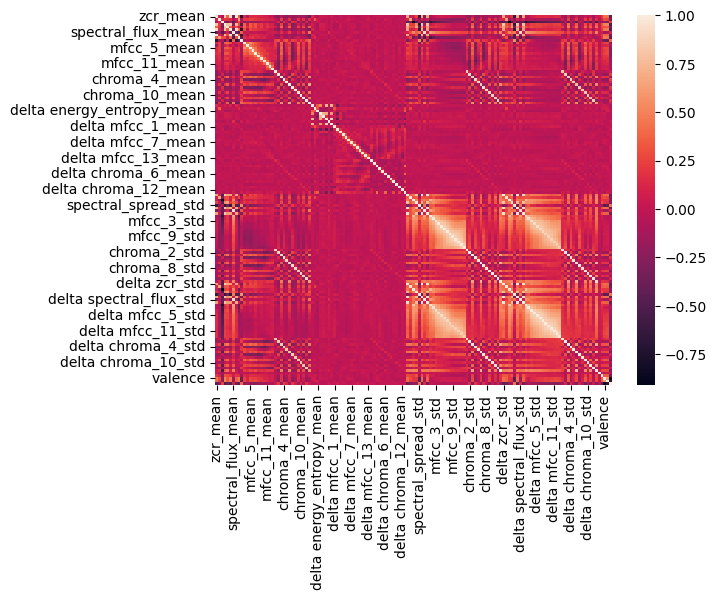

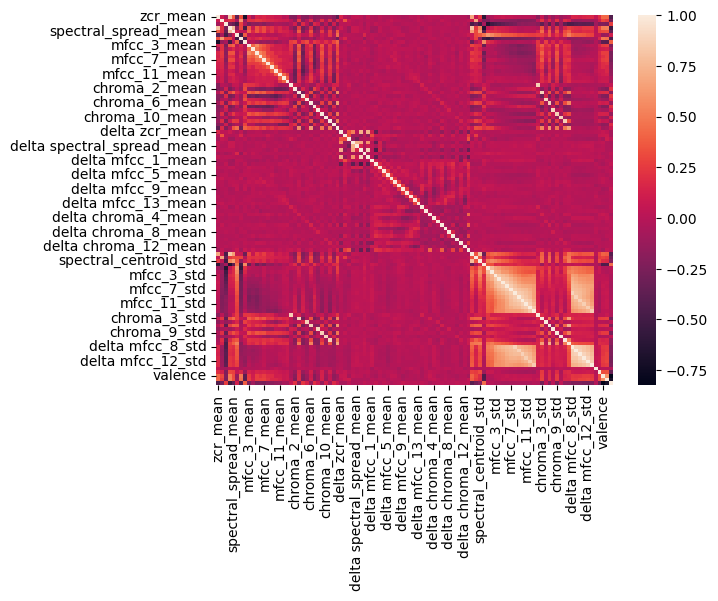

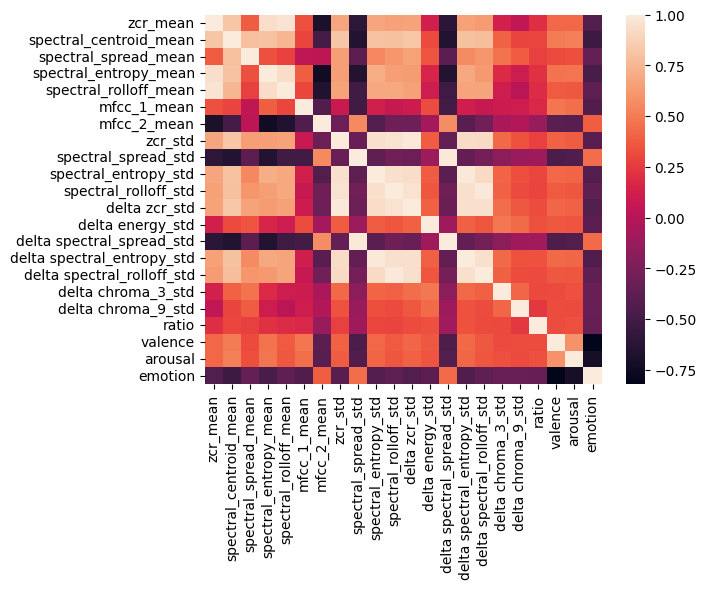

<Figure size 640x480 with 0 Axes>

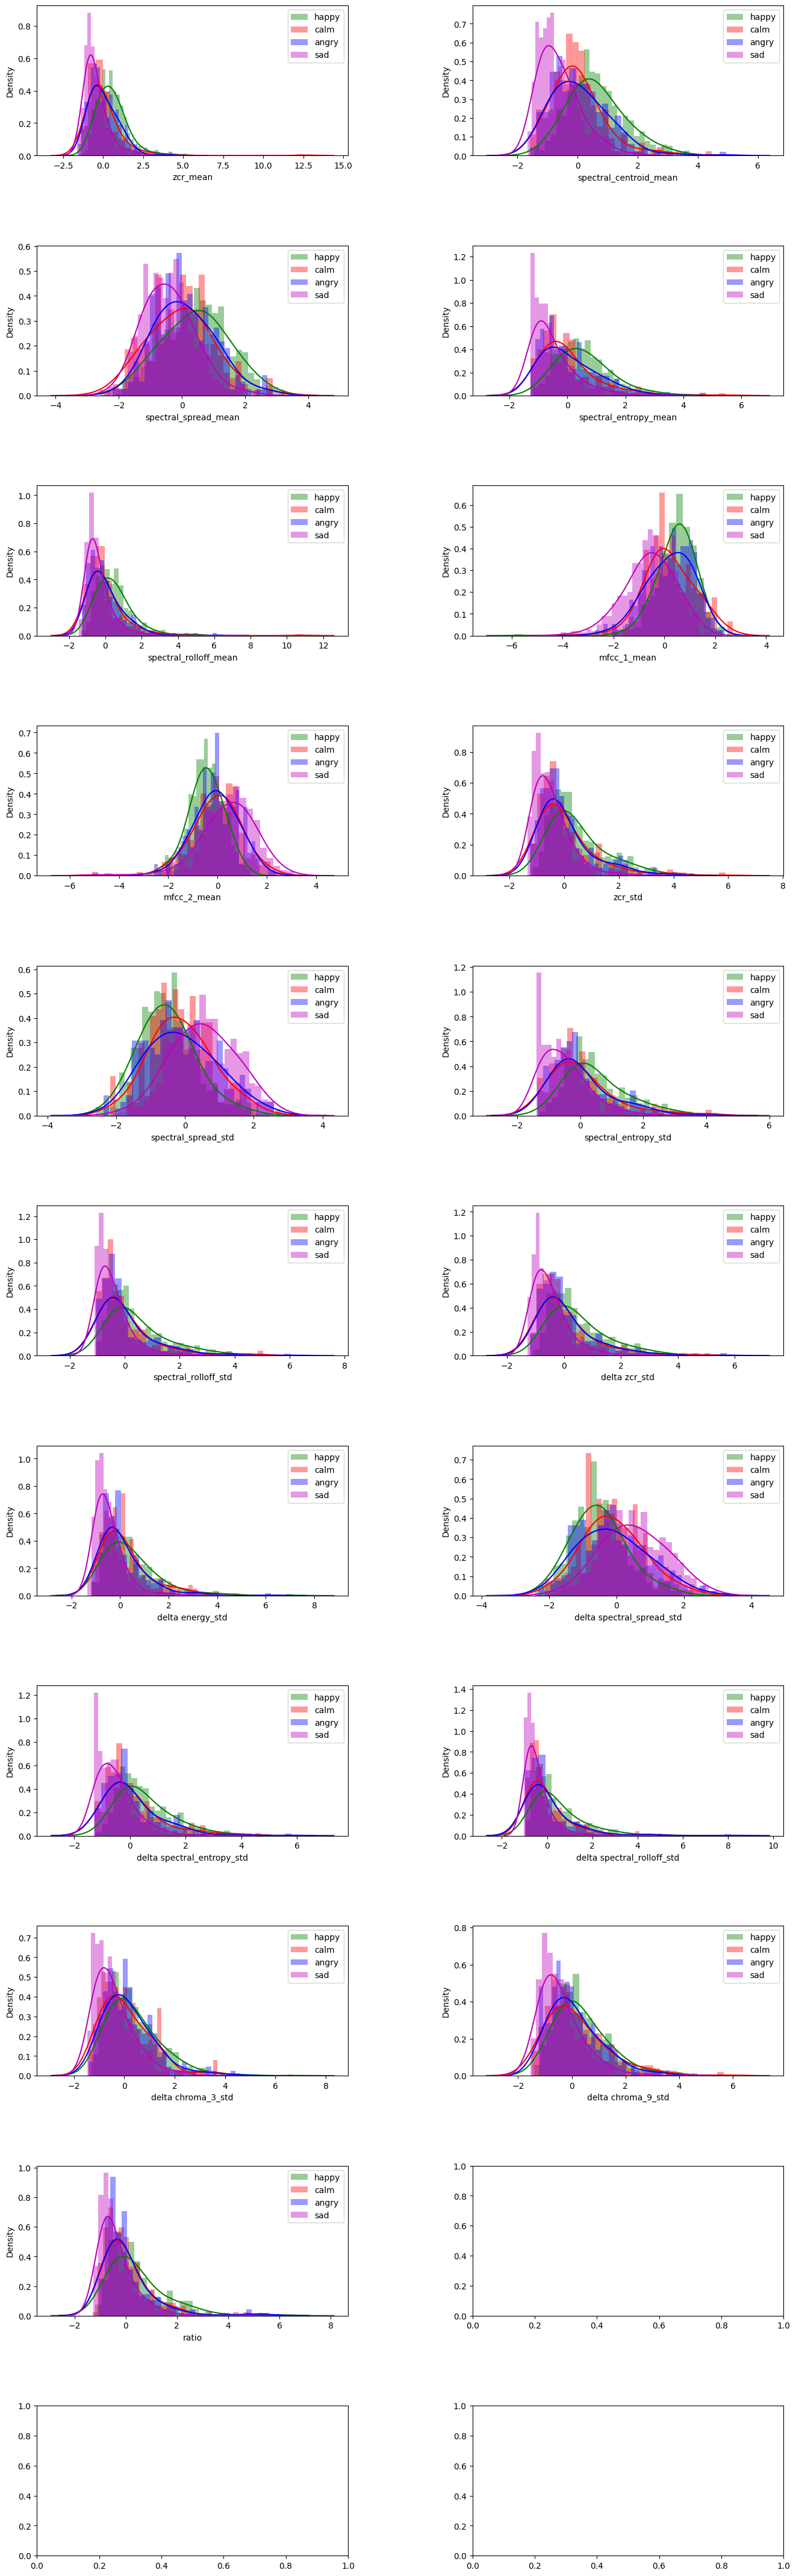

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

np.random.seed(123)

no_deltas = False
if no_deltas == True:
    data = short_term
else:
    # this is the csv we extracted in previous step.
    # it contains all audio and valence&arousal features
    data = csv_to_pd(feature_path)
    data = data.drop(columns=['song_id'])
    print(data.info())

###STEP1 FEATURES VS FEATURES::::
#get correlation matrix
plt.figure()
corr = data.corr()
# Generate correlation heatmap
sns.heatmap(corr)
plt.figure()

# filter the values: because we have too many fearues (130x130) approximate matrix!
# we cannot conclude by looking at the heatmap.
# so, set a threshold for which we will consider the features
num_of_feats = corr.shape[0]
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
# Get selected cols
selected_columns = data.columns[columns]
data1 = data[selected_columns]
corr1 = data1.corr()
print(f'Dataset after { len(data.columns) - len(selected_columns) } dependent features droped: ', data1.head())
sns.heatmap(corr1)
plt.figure()

###STEP2 FEATURES VS LABELS::::
#get features with high correlation to the labels
corr_matrix = data.corr()
corr_matrix["emotion"].sort_values(ascending=False)

num_of_feats = corr_matrix.shape[0]
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
label_column = corr_matrix.iloc[:, -1]
for i in range(corr_matrix.shape[0]):
    if abs(label_column[i]) <= 0.3:
            columns[i] = False

# Get selected cols
selected_columnsf = data.columns[columns]
data2 = data[selected_columnsf]
corr2 = data2.corr()
print(f'Dataset after {len(data.columns) - len(selected_columnsf) } dependent features droped: ', data2.head())
sns.heatmap(corr2)
plt.show()
plt.figure()

#### PLOT THE DISTRIBUTION OF EACH SELECTED FEATURE
result = pd.DataFrame()
result['emotion'] = data.iloc[:,-1]
j = 1
subrows = (len(data2.columns) + 1) // 2
fig, axs = plt.subplots(subrows, 2, figsize=(16, 5*subrows))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i in data2.columns[:-3]:
    plt.subplot(subrows, 2, j)
    sns.distplot(data2[i][result['emotion']==1], color='g', label = 'happy', bins=30, kde_kws={'bw': 0.5})
    sns.distplot(data2[i][result['emotion']==2], color='r', label = 'calm', bins=30, kde_kws={'bw': 0.5})
    sns.distplot(data2[i][result['emotion']==3], color='b', label = 'angry', bins=30, kde_kws={'bw': 0.5})
    sns.distplot(data2[i][result['emotion']==4], color='m', label = 'sad', bins=30, kde_kws={'bw': 0.5})
    plt.legend(loc='best')
    j += 1

plt.show()
# Selecting useful features from training and test data
# if datta=1, take the filttered features from features vs features
# else from features vs labels
datta = 2
if datta == 1:
    X_filtered = np.array(data1.iloc[:, :-3].values)#.T
    y_filtered = np.array(data1['emotion'])
    y_full_filtered = np.array([data1['valence'],data1['arousal']])
else:
    X_filtered = np.array(data2.iloc[:, :-3].values)#.T
    y_filtered = np.array(data2['emotion'])
    y_full_filtered = np.array([data2['valence'],data2['arousal']])
print('Selecting features...')
print(y_filtered.shape, X_filtered.shape)


### mRMR

In [ ]:
### Download dependencies
!pip install numpy Cython
!pip install -U pymrmr
!CC=gcc-10 CXX=g++-10 pip install -U pymrmr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymrmr: filename=pymrmr-0.1.11-cp310-cp310-linux_x86_64.whl size=390227 sha256=d27c5021919778c07b4b7c87a7e75207b8e5cd1db963581ffac6ab2ff3989f32
  Stored in directory: /root/.cache/pip/wheels/46/ae/55/4a2479c5f0de7eb363fe970cb18e4a750e03e4e63b1b5c2005
Successfully built pymrmr


In [ ]:
import pymrmr
import time

df = pd.read_csv('/content/drive/MyDrive/ai_unipi/MachineLearning/media/total_annotated_data.csv')
colnames = df.columns.tolist()
colnames = colnames[1:]
colnames = colnames[-1:] + colnames[:-4]
df = df[colnames]
print(df.head())
selected_cols = pymrmr.mRMR(df, 'MIQ', 20)
df = df[selected_cols]
print(df.shape)
X_filtered = np.array(df)#.T
y_filtered = np.array(data['emotion'])
y_full_filtered = np.array([data['valence'],data['arousal']])
print('Feature selection with mRMR: \n', selected_cols)
print(X_filtered.shape)

   emotion  zcr_mean  energy_mean  energy_entropy_mean  \
0      4.0 -0.174710    -0.774566             0.030276   
1      1.0  0.380791     1.045841             0.365854   
2      4.0  0.292477    -0.063243             0.840085   
3      4.0 -0.983304    -1.044797            -0.374764   
4      2.0 -0.344802    -1.084248            -2.433123   

   spectral_centroid_mean  spectral_spread_mean  spectral_entropy_mean  \
0               -0.200111             -0.004680              -0.193153   
1                0.377840              0.217572               0.305879   
2               -0.128733             -0.409315               0.145741   
3               -0.806344             -0.071832              -0.846609   
4                0.231515              0.188764               0.176503   

   spectral_flux_mean  spectral_rolloff_mean  mfcc_1_mean  ...  \
0            0.864971              -0.282300    -0.876862  ...   
1           -0.469400               0.270129     1.256673  ...   
2       

### Logistic Regression Ranking

https://github.com/tyiannak/ml-python/blob/main/notebooks/12-feature_selection.ipynb

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
# define the model
model_num = 2
data_num = 1 # 1: full dataset, 2: no std values, 3: no deltas or std values

if model_num == 1:
    model = LogisticRegression()
else:
    model = DecisionTreeRegressor()

if data_num == 1:
    X = np.array(data.iloc[:, :-3].values)#.T
    feature_names = data.columns.values
elif data_num == 2:
    X = np.array(midterm_mean.iloc[:, :-3].values)#.T
    feature_names = midterm_mean.columns.values
elif data_num == 3:
    X = np.array(short_term.iloc[:, :-3].values)#.T
    feature_names = short_term.columns.values

print(X.shape)
model.fit(X, y.reshape(-1))

# get importance
if model_num == 1:
    importance = model.coef_
    importance = np.abs(importance[0])
else:
    importance = model.feature_importances_
    print(importance.shape)
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    #imp_features = [f for i_f, f in enumerate(feature_names_s) if abs(importance[i_f]) < 0.05]

# gets the names in ascending importance order
feature_names_s = [feature_names[f] for f in importance.argsort()]
print(feature_names)
# Get the 10 least and most important features
less_important_5 = feature_names_s[:10]
most_important_5 = feature_names_s[:-11:-1]
print("Less important features:")
print(less_important_5)
print("Most important features:")
print(most_important_5)

df = data[most_important_5]
print(df)
X_filtered = np.array(df.iloc[:, :-3].values)#.T
y_filtered = np.array(data['emotion'])
print(X_filtered.shape)

(1744, 139)
(139,)
Feature: 0, Score: 0.00175
Feature: 1, Score: 0.01277
Feature: 2, Score: 0.01400
Feature: 3, Score: 0.26099
Feature: 4, Score: 0.00181
Feature: 5, Score: 0.06063
Feature: 6, Score: 0.00211
Feature: 7, Score: 0.00742
Feature: 8, Score: 0.09392
Feature: 9, Score: 0.00645
Feature: 10, Score: 0.00066
Feature: 11, Score: 0.00231
Feature: 12, Score: 0.00245
Feature: 13, Score: 0.00757
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00496
Feature: 16, Score: 0.00057
Feature: 17, Score: 0.00037
Feature: 18, Score: 0.00491
Feature: 19, Score: 0.00487
Feature: 20, Score: 0.00149
Feature: 21, Score: 0.00282
Feature: 22, Score: 0.01387
Feature: 23, Score: 0.00016
Feature: 24, Score: 0.00792
Feature: 25, Score: 0.00467
Feature: 26, Score: 0.00116
Feature: 27, Score: 0.00422
Feature: 28, Score: 0.00180
Feature: 29, Score: 0.01098
Feature: 30, Score: 0.00899
Feature: 31, Score: 0.00298
Feature: 32, Score: 0.00131
Feature: 33, Score: 0.00175
Feature: 34, Score: 0.00031
Feature: 35

## Data split



Our dataset is consists of songs of different kind of genres with each genre having different emotions and as depicted earlier, all classes seem well distributed.

To split the dataset to train and test datasets, we will use repeated KFold method to also do cross-validation on the dataset.

We divide the dataset to:
* 80% training dataset
* 10% validation dataset
* 10% testing dataset

In [ ]:
#### COME HERE AFTER FEATURE SELECTION (for better results) -- X_filtered
# Do not random split -
from sklearn.model_selection import train_test_split

print(X, '\n\n', X_filtered.shape, y_filtered.shape)

x_train, x_test, y_train, y_test = train_test_split(X_filtered, y_filtered, random_state=0, shuffle=True, test_size = 0.10)#, stratify=y_filtered)
print('X initial data =', X.shape, ', X_train size =', x_train.shape, ', x_test size =', x_test.shape)
# validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.12, random_state=1)
print('X_train size =', x_train.shape, ', x_val size =', x_val.shape)

# Drop the corresponding entries from X_train
'''
df = data
indices_to_delete = df[df['emotion'] == 1.0].index[:450]
indices_to_delete2 = df[df['emotion'] == 4.0].index[:450]
print(indices_to_delete)
df_balanced = df.drop(indices_to_delete)
print(df_balanced.shape)
df_balanced = df_balanced.drop(indices_to_delete2)
print(df_balanced.shape)
print(df_balanced.emotion)
plt.title('Count of Emotions', size=16)
sns.countplot(x='emotion', data=df_balanced)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

X_filtered = df_balanced.iloc[:, :-3].copy()
# do the mRMR selection
X_filtered = np.array(X_filtered[most_important_5].values)
y_filtered = np.array(df_balanced['emotion'])
y_full_filtered = np.array([df_balanced['valence'],df_balanced['arousal']])
print(X_filtered.shape)

x_train, x_test, y_train, y_test = train_test_split(X_filtered, y_filtered, random_state=0, shuffle=True, test_size = 0.10, stratify=y_filtered)
print('X initial data =', X.shape, ', X_train size =', x_train.shape, ', x_test size =', x_test.shape)
# validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.12, random_state=1)
print('X_train size =', x_train.shape, ', x_val size =', x_val.shape)
'''

[[-1.74709836e-01 -7.74566012e-01  3.02759973e-02 ...  1.72405530e+00
  -3.05389308e-01  1.00000000e+01]
 [ 3.80790782e-01  1.04584078e+00  3.65854373e-01 ...  8.47607654e-02
   3.79391197e-01  1.00000000e+03]
 [ 2.92476571e-01 -6.32429380e-02  8.40085462e-01 ... -3.83609102e-01
  -1.83831525e-01  1.00100000e+03]
 ...
 [ 7.85507015e-01  4.84074770e-03 -7.40912547e-01 ... -3.83609102e-01
   8.56922894e-01  9.96000000e+02]
 [ 4.87497105e-01  4.39202943e-01 -1.93055292e+00 ... -3.83609102e-01
  -5.24315931e-01  9.97000000e+02]
 [-1.18367041e-01 -2.47395603e-01 -3.62522541e-01 ... -1.68063335e+00
   3.14354849e-01  9.99000000e+02]] 

 (1744, 20) (1744,)
X initial data = (1744, 139) , X_train size = (1569, 20) , x_test size = (175, 20)
X_train size = (1380, 20) , x_val size = (189, 20)


"\ndf = data\nindices_to_delete = df[df['emotion'] == 1.0].index[:450]\nindices_to_delete2 = df[df['emotion'] == 4.0].index[:450]\nprint(indices_to_delete)\ndf_balanced = df.drop(indices_to_delete)\nprint(df_balanced.shape)\ndf_balanced = df_balanced.drop(indices_to_delete2)\nprint(df_balanced.shape)\nprint(df_balanced.emotion)\nplt.title('Count of Emotions', size=16)\nsns.countplot(x='emotion', data=df_balanced)\nplt.ylabel('Count')\nplt.xlabel('Emotions')\nsns.despine(top=True, right=True, left=False, bottom=False)\nplt.show()\n\nX_filtered = df_balanced.iloc[:, :-3].copy()\n# do the mRMR selection\nX_filtered = np.array(X_filtered[most_important_5].values)\ny_filtered = np.array(df_balanced['emotion'])\ny_full_filtered = np.array([df_balanced['valence'],df_balanced['arousal']])\nprint(X_filtered.shape)\n\nx_train, x_test, y_train, y_test = train_test_split(X_filtered, y_filtered, random_state=0, shuffle=True, test_size = 0.10, stratify=y_filtered)\nprint('X initial data =', X.shape,

As mentioned, our dataset suffers from imbalance. To help with that, we apply SMOTE oversampling technique on our weak classes after splitting on our training dataset.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
print('Original dataset shape %s' % Counter(y))
# Perform undersampling on X_train and y_train
X_undersampled, y_undersampled = undersampler.fit_resample(x_train, y_train) #X_filtered
print('After downsampling dataset shape %s' % Counter(y_undersampled))


# Oversampling
sm = SMOTE(random_state=42)
X_oversampled, y_oversampled = sm.fit_resample(x_train, y_train)
print('After oversampling dataset shape %s' % Counter(y_oversampled))


# choose to change the training dataset to the oversampled one
randomdownsample = 3
if randomdownsample == 2:
    x_train = X_undersampled
    y_train = y_undersampled
elif randomdownsample == 3:
    x_train = X_oversampled
    y_train = y_oversampled

## Training
Classification to label 'emotion' with acoustic features.

Use of RepeatedKFold cross-validation with SVC model for classification.
For each fold, we save the accuracy, f1 score and after trainig we plot the means of these evaluation metrics.

ALTERNATIVELY:
**Hyperparameter tuning**:

Cross-validation with GridSearch for finding best hyperparameters on the training model.

https://github.com/jmcabreira-zz/Data-Science-Projects/blob/master/A-Music-Taste-Analysis-Using-Spotify-API-and-Python./Playlist_analysis_%20.ipynb

Possible model types trained:
* Simple SVC
* Gridsearch SVC
* KFold GridSearch SVC
* RepeatKFold SVC

Experiments were also done with RandomForest classifier instead of SVC.

BEST MODEL: KFold GridSearch with RandomFroest classifier

In [ ]:
##### simple without gridsearch

clf = svm.SVC(probability=True)

clf.fit(x_train, y_train)                 # train the classifier
y_test_pred = clf.predict(x_test)
print(y_test, y_test_pred)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))
test_acc  = (np.count_nonzero(y_test==y_test_pred) / len(y_test_pred))
y_pred = clf.predict(x_train)
train_acc = (np.count_nonzero(y_train==y_pred) / len(y_pred))
print(f'SVC classification accuracy: {100*test_acc:.2f}%')
print(f'SVC classification train accuracy: {100*train_acc:.2f}%')

print(y_pred.shape)
print(y_train.shape)

[1. 3. 4. 1. 1. 3. 4. 3. 1. 1. 4. 1. 1. 1. 4. 4. 4. 1. 4. 1. 3. 4. 2. 1.
 1. 4. 4. 1. 1. 4. 4. 2. 1. 4. 4. 2. 1. 4. 4. 3. 4. 1. 1. 1. 1. 2. 4. 3.
 1. 4. 2. 1. 4. 1. 3. 2. 1. 3. 4. 1. 2. 1. 1. 1. 3. 1. 4. 2. 4. 4. 2. 1.
 1. 1. 1. 4. 4. 1. 1. 3. 1. 4. 1. 1. 1. 3. 2. 3. 1. 3. 4. 1. 4. 4. 4. 2.
 1. 4. 1. 3. 4. 1. 4. 4. 4. 1. 1. 4. 4. 4. 1. 3. 4. 3. 2. 1. 1. 1. 1. 2.
 1. 4. 4. 2. 1. 4. 4. 1. 4. 2. 1. 2. 4. 4. 4. 2. 1. 3. 1. 1. 4. 4. 2. 4.
 1. 3. 4. 3. 1. 4. 2. 1. 4. 4. 4. 4. 1. 2. 3. 2. 1. 1. 1. 4. 1. 1. 4. 4.
 4. 1. 1. 1. 4. 1. 1.] [4. 1. 4. 2. 1. 2. 4. 3. 1. 1. 4. 3. 1. 1. 4. 1. 4. 2. 4. 1. 1. 4. 4. 1.
 1. 4. 3. 1. 4. 2. 4. 3. 1. 4. 2. 3. 2. 4. 4. 1. 4. 1. 2. 1. 1. 4. 2. 2.
 1. 4. 2. 1. 1. 1. 3. 4. 1. 3. 3. 1. 4. 1. 1. 1. 4. 1. 2. 2. 4. 4. 3. 1.
 1. 1. 1. 4. 4. 1. 4. 4. 3. 4. 1. 3. 1. 2. 2. 1. 4. 2. 4. 1. 3. 3. 4. 1.
 2. 4. 1. 1. 4. 1. 4. 2. 4. 4. 3. 2. 3. 4. 1. 4. 2. 4. 1. 3. 1. 1. 1. 3.
 1. 3. 4. 1. 4. 4. 4. 1. 4. 3. 2. 4. 4. 4. 4. 2. 3. 2. 3. 2. 3. 4. 2. 4.
 1. 3. 4. 3. 1. 4. 2. 3. 4. 

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

print(x_train.shape)

param_grid = {
    'C': [0.1, 1, 2, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
clf = svm.SVC(probability=True)
# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test)

validation_accuracy = best_model.score(x_val, y_val)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Validation Accuracy:", validation_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

test_acc  = (np.count_nonzero(y_test==y_test_pred) / len(y_test_pred))
y_pred = best_model.predict(x_train)
train_acc = (np.count_nonzero(y_train==y_pred) / len(y_pred))
print(f'SVC classification accuracy: {100*test_acc:.2f}%')
print(f'SVC classification train accuracy: {100*train_acc:.2f}%')

print(y_pred.shape)
print(y_train.shape)

'''
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred_tree = clf.predict(x_test)
test_acc  = (np.count_nonzero(y_test==y_pred_tree) / len(y_pred_tree))
y_pred_tree = clf.predict(x_train)
train_acc = (np.count_nonzero(y_train==y_pred_tree) / len(y_pred_tree))

print(f'Decision Tree classification accuracy: {100*test_acc:.2f}%')
print(f'Decision Tree classification train accuracy: {100*train_acc:.2f}%')
'''

(2192, 20)
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.8485692888569913
Validation Accuracy: 0.5555555555555556
Classification Report:
              precision    recall  f1-score   support

         1.0       0.71      0.72      0.72        72
         2.0       0.20      0.14      0.17        21
         3.0       0.11      0.10      0.11        20
         4.0       0.64      0.71      0.67        62

    accuracy                           0.58       175
   macro avg       0.42      0.42      0.42       175
weighted avg       0.56      0.58      0.57       175

SVC classification accuracy: 57.71%
SVC classification train accuracy: 99.82%
(2192,)
(2192,)


"\nfrom sklearn.tree import DecisionTreeClassifier\nclf = DecisionTreeClassifier()\nclf.fit(x_train, y_train)\ny_pred_tree = clf.predict(x_test)\ntest_acc  = (np.count_nonzero(y_test==y_pred_tree) / len(y_pred_tree))\ny_pred_tree = clf.predict(x_train)\ntrain_acc = (np.count_nonzero(y_train==y_pred_tree) / len(y_pred_tree))\n\nprint(f'Decision Tree classification accuracy: {100*test_acc:.2f}%')\nprint(f'Decision Tree classification train accuracy: {100*train_acc:.2f}%')\n"

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

print(x_train.shape)

param_grid = {
    'C': [0.1, 1, 2, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
clf = svm.SVC(probability=True)
# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test)

validation_accuracy = best_model.score(x_val, y_val)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Validation Accuracy:", validation_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

test_acc  = (np.count_nonzero(y_test==y_test_pred) / len(y_test_pred))
y_pred = best_model.predict(x_train)
train_acc = (np.count_nonzero(y_train==y_pred) / len(y_pred))
print(f'SVC classification accuracy: {100*test_acc:.2f}%')
print(f'SVC classification train accuracy: {100*train_acc:.2f}%')

print(y_pred.shape)
print(y_train.shape)

'''
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred_tree = clf.predict(x_test)
test_acc  = (np.count_nonzero(y_test==y_pred_tree) / len(y_pred_tree))
y_pred_tree = clf.predict(x_train)
train_acc = (np.count_nonzero(y_train==y_pred_tree) / len(y_pred_tree))

print(f'Decision Tree classification accuracy: {100*test_acc:.2f}%')
print(f'Decision Tree classification train accuracy: {100*train_acc:.2f}%')
'''

(2125, 10)
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.6983529411764706
Validation Accuracy: 0.7172413793103448
Classification Report:
              precision    recall  f1-score   support

         1.0       0.73      0.75      0.74        61
         2.0       0.85      0.78      0.81        67
         3.0       0.81      0.91      0.85        74
         4.0       0.71      0.66      0.68        67

    accuracy                           0.78       269
   macro avg       0.77      0.77      0.77       269
weighted avg       0.78      0.78      0.78       269

SVC classification accuracy: 77.70%
SVC classification train accuracy: 95.29%
(2125,)
(2125,)


"\nfrom sklearn.tree import DecisionTreeClassifier\nclf = DecisionTreeClassifier()\nclf.fit(x_train, y_train)\ny_pred_tree = clf.predict(x_test)\ntest_acc  = (np.count_nonzero(y_test==y_pred_tree) / len(y_pred_tree))\ny_pred_tree = clf.predict(x_train)\ntrain_acc = (np.count_nonzero(y_train==y_pred_tree) / len(y_pred_tree))\n\nprint(f'Decision Tree classification accuracy: {100*test_acc:.2f}%')\nprint(f'Decision Tree classification train accuracy: {100*train_acc:.2f}%')\n"

### Cross-validation

(1744, 100)


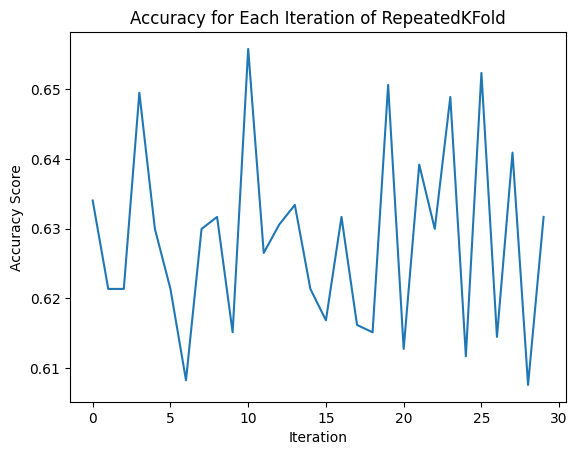

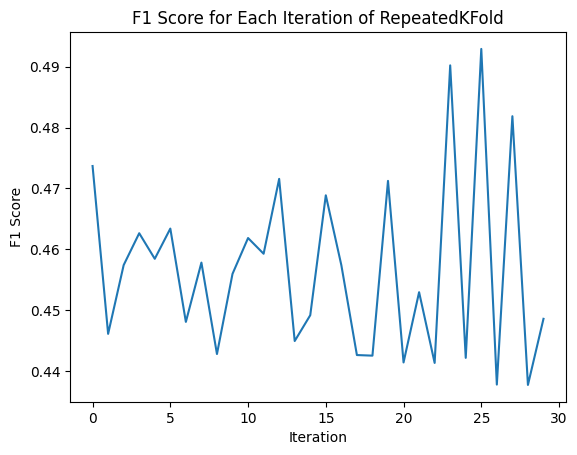

In [ ]:
# After getting the best hyperparameters, train with RepeatedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn import svm
from sklearn import metrics

rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=0)
accuracy = []
f1_scores = []
print(X_filtered.shape)
clf = svm.SVC(kernel='rbf', C=10, probability=True)
for i_train, i_test in rkf.split(X_filtered, y_filtered): # for each split/repeat
    # get train/test based on the indices of split()
    X_train, X_test = X_filtered[i_train, :], X_filtered[i_test, :]
    y_train, y_test = y_filtered[i_train], y_filtered[i_test]

    clf.fit(X_train, y_train)            # train the model
    y_pred = clf.predict(X_test)         # predict
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred, average='macro'))

accuracy = np.array(accuracy)
f1_scores = np.array(f1_scores)

plt.plot(accuracy)
plt.xlabel('Iteration')
plt.ylabel('Accuracy Score')
plt.title('Accuracy for Each Iteration of RepeatedKFold')
plt.show()
plt.plot(f1_scores)
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Iteration of RepeatedKFold')
plt.show()

In [ ]:
# Stratified KFold shufflesplit gridsearch
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly']
}

clf = SVC(probability=True)
k_fold = KFold(n_splits=3, shuffle=True, random_state=42)  # Define your k value
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=k_fold, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(x_test)
# Obtain the predicted probabilities for the test set
y_probabilities = best_model.predict_proba(x_test)

validation_accuracy = best_model.score(x_test, y_test)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", validation_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.8083903328773371
Test Accuracy: 0.5771428571428572
Classification Report:
              precision    recall  f1-score   support

         1.0       0.71      0.72      0.72        72
         2.0       0.20      0.14      0.17        21
         3.0       0.11      0.10      0.11        20
         4.0       0.64      0.71      0.67        62

    accuracy                           0.58       175
   macro avg       0.42      0.42      0.42       175
weighted avg       0.56      0.58      0.57       175



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
print(clf.predict([[0, 0, 0, 0]]))

[1]


While without imbalance split techniques, we get a far better score that after downsampling (70% compared to 48% after downsampling and 55% with oversampling), after evaluating our model in the next step we can see that this accuracy score is misleading. As we can also see from the predicted classes we print above, it is due to mere lack of the overpopulation of the prominent classes that we get correct predictions, while the classes that are not prominent never get predicted (falsenegative)

full dataset (data_num = 1) + regressiontree selection:

- SVC classification accuracy: 69.71%
- SVC classification train accuracy: 67.90%

***Midterm no std dataset (data_num = 2) + regressiontree selection:***

- SVC classification accuracy: 70.86%
- SVC classification train accuracy: 67.75%

***Midterm no std no deltas dataset (data_num = 3) + regressiontree selection:***

- SVC classification accuracy: 70.86%
- SVC classification train accuracy: 67.68%

----

full dataset (data_num = 1) + logistic selection:

- SVC classification accuracy: 64.57%
- SVC classification train accuracy: 65.58%

Midterm no std dataset (data_num = 2) + logistic selection:

- SVC classification accuracy: 68.57%
- SVC classification train accuracy: 68.48%

Midterm no std no deltas dataset (data_num = 3) + logistic selection:

- SVC classification accuracy: 68.57%
- SVC classification train accuracy: 68.48%

---
Dataset 2 and 3 are similar, so i will only try datasets 1 and 3 from now on.

Better results with dataset without std values and with decision tree feature selection.

---
Different SVM kernel (above was for default RBF (kernel = 1))::

full dataset (data_num = 1) + logistic selection + linear (kernel = 3):

- SVC classification accuracy: 66.29%
- SVC classification train accuracy: 64.06%

full dataset (data_num = 1) + logistic selection + poly (kernel = 2):

- SVC classification accuracy: 62.86%
- SVC classification train accuracy: 63.77%

Midterm no std no deltas dataset (data_num = 3) + logistic selection + linear (kernel = 3):

- SVC classification accuracy: 69.71%
- SVC classification train accuracy: 65.94%

Midterm no std no deltas dataset (data_num = 3) + logistic selection + poly (kernel = 2):

- SVC classification accuracy: 66.29%
- SVC classification train accuracy: 68.12%

----

Best model: No std dataset with decision tree selection and RBF (default) SVM kernel

(1380,)
(270, 7)
[[ 0.91103515  0.94944682 -0.78041782 ... -0.71228362 -0.06003516
  -1.24966658]
 [ 1.35345972  0.97969484 -0.38288834 ...  0.74278386  0.4117878
  -0.66753124]
 [ 0.15056501 -0.74934772  2.49994278 ...  0.5557547  -1.49979243
   0.55483448]
 ...
 [-0.48158373  0.88225065  0.05012637 ...  0.25073567  0.62395748
  -1.25736604]
 [ 0.00710585  0.26992611 -0.84082166 ... -0.19241907  0.83895166
  -0.30456991]
 [-0.19719072  0.90219721 -1.27070524 ... -0.18795853  0.54495019
   0.33814726]]
(245, 7)


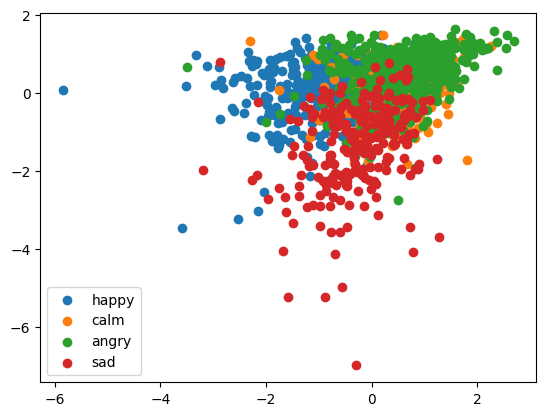

Adjusted Mutual Information (AMI): 0.14892600948597828
Adjusted Rand Index (ARI): 0.16603274803924578


In [ ]:
# dataset split
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming X is your feature matrix
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_train)

# Get cluster assignments for each data point
cluster_labels = kmeans.predict(x_train)

print(cluster_labels.shape)

filtered_label1 = x_train[cluster_labels == 1]
filtered_label2 = x_train[cluster_labels == 2]
filtered_label3 = x_train[cluster_labels == 3]
filtered_label4 = x_train[cluster_labels == 4]
print(filtered_label1.shape)
#Plotting the results
u_labels = np.unique(cluster_labels)
emotions = ['happy','calm','angry','sad']
print(x_train)
print(x_train[cluster_labels == 3 , :].shape)
for i in u_labels:
    plt.scatter(x_train[cluster_labels == i , 0] , x_train[cluster_labels == i , 1] , label = emotions[i])
plt.legend()
plt.show()

#### Print accuracy
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
ami = adjusted_mutual_info_score(y_train, cluster_labels)
ari = adjusted_rand_score(y_train, cluster_labels)
print("Adjusted Mutual Information (AMI):", ami)
print("Adjusted Rand Index (ARI):", ari)

## Evaluation


To evaluate our classifier's accuracy, we calculate the Confusion Matrix as a visualization method on the predicted and real labels of the test dataseet:

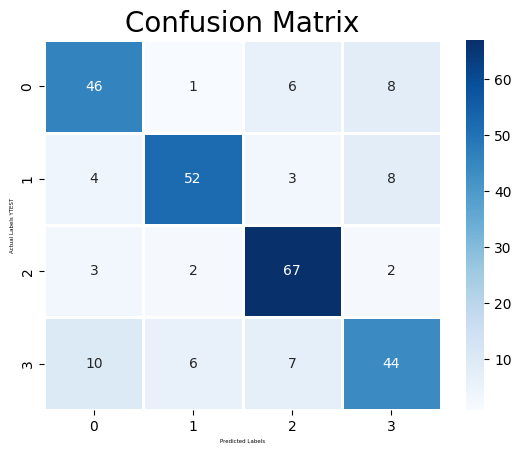

Text(50.722222222222214, 0.5, 'Actual Labels YTRAIN')

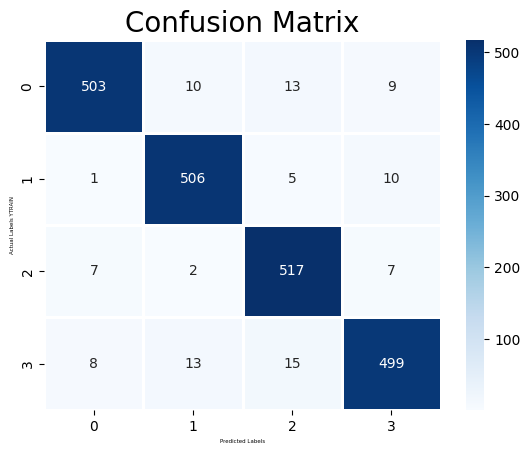

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import sns

emotions = {1:"happy", 2:"calm", 3:"angry", 4:"sad"}
## Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
#cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=4)
plt.ylabel('Actual Labels YTEST', size=4)
plt.show()

cm = confusion_matrix(y_train, y_pred)
#cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=4)
plt.ylabel('Actual Labels YTRAIN', size=4)


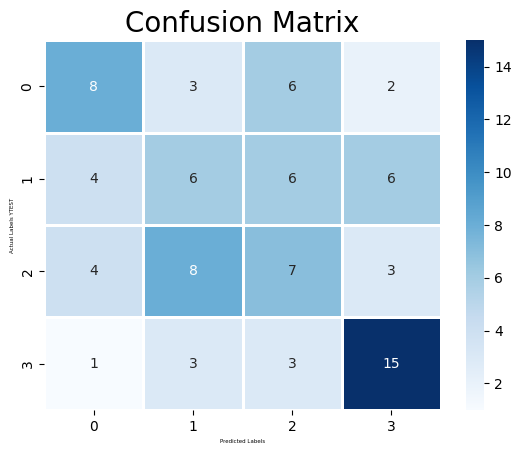

Text(50.722222222222214, 0.5, 'Actual Labels YTRAIN')

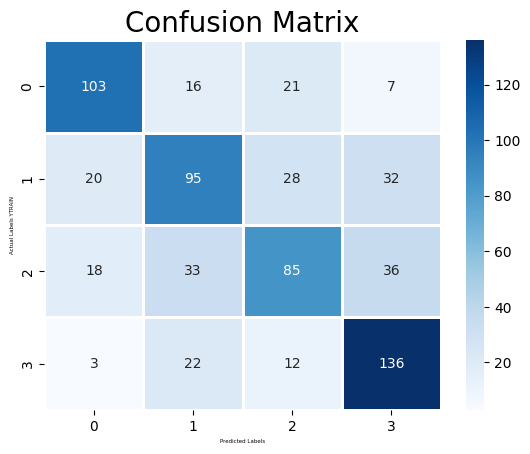

In [ ]:
### WITJHOUT OVERSAMPLING

from sklearn.metrics import confusion_matrix, classification_report

emotions = ["happy", "calm", "angry", "sad"]
## Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=emotions)
#cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=4)
plt.ylabel('Actual Labels YTEST', size=4)
plt.show()

cm = confusion_matrix(y_train, y_pred, labels = emotions)
#cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=4)
plt.ylabel('Actual Labels YTRAIN', size=4)


In [ ]:
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

         1.0       0.47      0.42      0.44        19
         2.0       0.30      0.27      0.29        22
         3.0       0.32      0.32      0.32        22
         4.0       0.58      0.68      0.62        22

    accuracy                           0.42        85
   macro avg       0.42      0.42      0.42        85
weighted avg       0.41      0.42      0.42        85



In [ ]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn import metrics
def accuracy(clf, data, target):
    results = cross_val_predict(clf, data.reshape(-1, 1) ,target.reshape(-1, 1) ,cv = 5)
    return metrics.accuracy_score(target,results)
#lasso = linear_model.Lasso()

accuracy(clf, y_test_pred, y_test)

0.5427509293680297

### ROC-AUC and Precision-Recall Curves
The ROC/ AUC evaluation is used mainly for classifying the performance between different models. The higher the accuracy, the higher in the Y axis the curve will be.
Precision-Recal is a similar evaluation estimation, where again the higher the curve, the better the accuracy


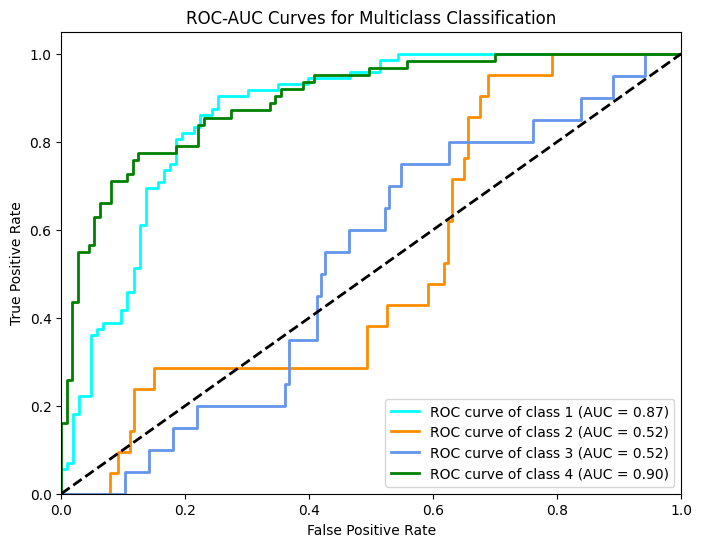

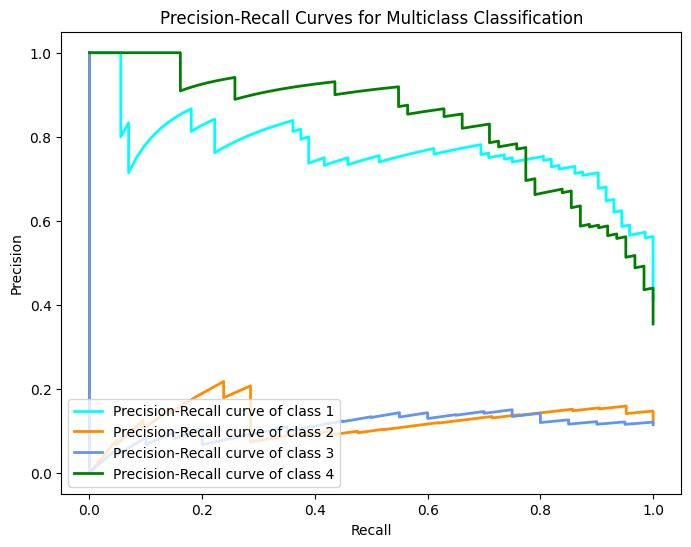

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
n_classes = 4  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
thresholds = dict()
y_test_binary = label_binarize(y_test,classes=[1, 2, 3, 4])  # Binarize the true labels
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binary[:, i], y_probabilities[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

# Plot precision recal
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0}'.format(i+1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multiclass Classification')
plt.legend(loc="lower left")
plt.show()